In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 19 17:08:19 2024

@author: Rodrigo Meira
"""
from libs.eos_database import *
from libs.compressor_class import *
from libs.compression import *
from libs.gc_eos_soave import *
from libs.viscosity import *
from libs.plenum_system import *
from libs.simulation import *
from libs.model import *

from casadi import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
from sklearn.model_selection import train_test_split

In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

vlv = valve(kv=0.38)
Vpp = 2.0 
Lc = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4500, None, 1, 0, Aij, volumn_desviation, 'gas')
comp = CompressorClass()
visc = viscosity(mixture, volumn_desviation)
compressor = compression(gas, comp, visc)
plenum_sys = plenum(gas, compressor, vlv, Vpp, Lc, A1)

In [3]:
nAlphas = 200

sampler_N_RotS = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS = sampler_N_RotS.random(n=nAlphas+1)
N_RotS = qmc.scale(samples_N_RotS, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas = qmc.LatinHypercube(d=1)
samples_alphas = sampler_alphas.random(n=nAlphas+1)
alphas = qmc.scale(samples_alphas, 0.4, 0.65).flatten()

nData = 600
dt = 0.5
timestep = 3
x0 = [14.9919, 339.69, 0.42885]
z0 = [6245.39, 6245.39, 321.672, 0.445562, 319.423, 0.503621, 320.097, 0.396345, 339.69, 0.42885, 0.514917]
u0 = [4500, 300, 600, alphas[0], 5000]

In [4]:
# sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas, alphas, N_RotS, nData, dt, timestep)
# x_values, z_values, time_steps, alpha_values, N_values, x_train, y_train, x_min, x_max, y_min,y_max = sim.run()

# sim_data = {
#     "x_values": x_values,
#     "z_values": z_values,
#     "time_steps": time_steps,
#     "x_train": x_train,
#     "y_train": y_train,
#     "x_min": x_min,
#     "x_max": x_max,
#     "y_min": y_min,
#     "y_max": y_max

# }

# np.savez(
#     "simulation_data.npz",
#     x_values=x_values,
#     z_values=z_values,
#     time_steps=time_steps,
#     alpha_values=alpha_values,
#     N_values=N_values,
#     x_train=x_train,
#     y_train=y_train,
#     x_min=x_min,
#     x_max=x_max,
#     y_min = y_min,
#     y_max = y_max

# )


In [ ]:
data = np.load("simulation_data.npz")

x_values = data["x_values"]
z_values = data["z_values"]
time_steps = data["time_steps"]
alpha_values = data["alpha_values"]
N_values = data["N_values"]
x_train = data["x_train"]
y_train = data["y_train"]
x_min = data["x_min"]
x_max = data["x_max"]
y_min = data["y_min"]
y_max = data["y_max"]


x_min = torch.tensor(x_min, dtype = torch.float32)
x_max = torch.tensor(x_max, dtype = torch.float32)
y_min = torch.tensor(y_min, dtype = torch.float32)
y_max = torch.tensor(y_max, dtype = torch.float32)
x_train = torch.tensor(np.array(x_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
y_min = y_train.amin(dim=(0), keepdim=True)
y_max = y_train.amax(dim=(0), keepdim=True)
x_train_split, X_val, y_train_split, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.3,  
    random_state=42,  
    shuffle=True      
)
y_train_split = y_train_split.squeeze()
y_val = y_val.squeeze()
train_dataset = torch.utils.data.TensorDataset(x_train_split, y_train_split)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 64, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= 64, shuffle=False)

torch.Size([119997, 14])
tensor([[10315.0664]])


In [6]:
model = MyModel(128, dt, x_max, x_min, y_min, y_max, plenum_sys)
train_loss_values = model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr= 1e-3,
    epochs=3,
    optimizers=torch.optim.Adam,
    patience=100,
    factor=0.5
)

/home/matheus/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/3], Train Loss: 16042.868776, Val Loss: 21717273.175844Learning Rate: 0.001000 physics_z: 188982724142419274827876054073344.000000
Epoch [2/3], Train Loss: 34.452538, Val Loss: 21477742.809947Learning Rate: 0.001000 physics_z: 974893222495547008.000000
Epoch [3/3], Train Loss: 34.452655, Val Loss: 21184606.099467Learning Rate: 0.001000 physics_z: 840802790548460800.000000


In [7]:
nAlphas_teste = 7

sampler_N_RotS_teste = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS_teste = sampler_N_RotS_teste.random(n=nAlphas_teste+1)
N_RotS_teste = qmc.scale(samples_N_RotS_teste, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas_teste = qmc.LatinHypercube(d=1)
samples_alphas_teste = sampler_alphas_teste.random(n=nAlphas_teste+1)
alphas_teste = qmc.scale(samples_alphas_teste, 0.4, 0.65).flatten()

sim2 = sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas_teste, alphas_teste, N_RotS_teste, nData, dt, timestep)
x_values_teste, z_values_teste, time_steps, alpha_values_teste, N_values_teste, x_teste, y_teste, x_min, x_max, y_min, y_max = sim.run()

CasADi - 2025-03-21 01:00:42 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


In [8]:
import torch

# Rodar a inferência corretamente
model.eval()  # Importante colocar a rede em modo de avaliação
with torch.no_grad():
    y_pred = model(x_teste)

# Checar se y_pred realmente varia
for name, param in model.named_parameters():
    print(f"{name}: mean={param.mean().item()}, std={param.std().item()}")



rnn_layer.weight_ih_l0: mean=0.01328246295452118, std=0.07287678122520447
rnn_layer.weight_hh_l0: mean=3.556431329343468e-05, std=0.060014624148607254
rnn_layer.bias_ih_l0: mean=2.2939755581319332e-05, std=0.058123935014009476
rnn_layer.bias_hh_l0: mean=-0.0025589095894247293, std=0.05769048258662224
rnn_layer.weight_ih_l1: mean=7.600239769089967e-05, std=0.05921340733766556
rnn_layer.weight_hh_l1: mean=0.00027367420261725783, std=0.05512993410229683
rnn_layer.bias_ih_l1: mean=0.010546207427978516, std=0.05906786769628525
rnn_layer.bias_hh_l1: mean=0.007131506688892841, std=0.05867793783545494
dense_layers.0.weight: mean=-0.0013759237481281161, std=0.05984143912792206
dense_layers.0.bias: mean=0.005214812234044075, std=0.07190358638763428
dense_layers.2.weight: mean=-0.004912520293146372, std=0.07521481812000275
dense_layers.2.bias: mean=0.039810217916965485, std=0.07777965068817139


tensor([9.4747e+00, 3.3499e+02, 3.5570e-01, 7.3392e+03, 7.4450e+03, 3.1671e+02,
        4.5043e-01, 3.1592e+02, 4.6361e-01, 3.3081e+02, 3.4442e-01, 3.3632e+02,
        3.5229e-01, 5.1492e-01])
tensor([2.6574e-01, 2.6574e-01, 5.5663e+03, 7.4021e+03, 7.4134e+03, 5.0956e+03,
        7.4956e+03, 7.2278e+03, 3.1290e+03, 5.3432e+03, 7.2503e+03, 2.6574e-01,
        4.4887e+03, 5.2084e+03])
tensor([2.6574e-01, 2.6574e-01, 5.6002e+03, 8.4066e+03, 8.3911e+03, 5.2955e+03,
        8.2806e+03, 7.0845e+03, 2.8101e+03, 5.6469e+03, 7.1881e+03, 2.6574e-01,
        4.2577e+03, 4.5630e+03])
torch.Size([4197, 14])


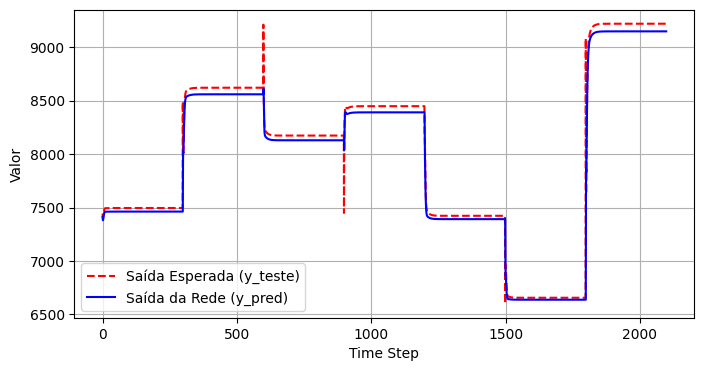

In [13]:
import matplotlib.pyplot as plt

print(y_teste[0, :])
print(y_pred[0, :])
print(y_pred[2000, :])
time_steps = time_steps[:y_teste.shape[0]]
# Remover dimensões extras de y_pred (se houver)
y_pred = y_pred.squeeze()
y_teste = y_teste.squeeze()
# Número de variáveis de saída
num_outputs = y_teste.shape[1]  

# Gerar 14 gráficos separadamente
plt.figure(figsize=(8, 4))  # Criar uma nova figura para cada gráfico
print(y_teste.shape)
plt.plot(time_steps, y_teste[:,4], label="Saída Esperada (y_teste)", color="red", linestyle="--")
plt.plot(time_steps, y_pred[:, 4], label="Saída da Rede (y_pred)", color="blue", linestyle="-")

plt.xlabel("Time Step")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)

plt.show()  # Mostrar cada gráfico individualmente
